In [2]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

##### Import libary

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import kaos
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)
import kaos
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
# import utility
import importlib
import pandas as pd

pd.set_option('mode.chained_assignment', None)
from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
# import r_boxplot_utils
import r_plot_utils
import kaos
import fcgr


In [4]:
kmer_length =10
fasta_file_path = "../../../data/GCF_000017985.1_ASM1798v1_genomic.fna"

In [5]:
def strip_whitespace_from_string_columns(input_df):
    """
    Returns a copy of the DataFrame with leading and trailing whitespace removed
    from all string/object columns.
    
    Args:
        input_df (pd.DataFrame): Input DataFrame to process.
    
    Returns:
        pd.DataFrame: Copy with whitespace stripped from all string columns.
    """
    cleaned_df = input_df.copy()
    for column in cleaned_df.select_dtypes(include=['object', 'string']):
        cleaned_df[column] = cleaned_df[column].str.strip()
    return cleaned_df

In [6]:
# LTEE_mutational_data

In [7]:
mutational_data_all_population = pd.read_csv("../../../data/LTEE_mutational_data.csv")
mutational_data_all_population = strip_whitespace_from_string_columns(mutational_data_all_population)


In [8]:
class Oligo:
    @staticmethod
    def kgain(mutational_data: pd.DataFrame, fasta_file_path: str, fasta_string: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos

        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        '#CHROM': chrom_id,
                        'POS': genome_pos,
                        "REF": ref_allele,
                        "ALT": alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)

        # Final mutation-level summary (per-mutation, sum across all windows)
        mutation_kmer_gain_df = (
            df_kmer_windows
            .groupby(['#CHROM','POS', "REF", "ALT", 'ref_flank_seq', 'mutated_flank_seq'])["window_gain"]
            .sum()
            .reset_index()
            .rename(columns={"window_gain": "kGain"})
        )

        return mutation_kmer_gain_df
    

    @staticmethod
    def window_wise_kgain(mutational_data: pd.DataFrame, fasta_string: str, fasta_file_path: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and window wise kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos
        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        # fasta_string = kaos.read_fasta(fasta_file_path)
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        "chromosome_id": chrom_id,
                        'genome_position': genome_pos,
                        'reference_allele': ref_allele,
                        'alternate_allele': alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)


        return df_kmer_windows


In [9]:
allele_counts_by_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
allele_counts_by_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop=True)
allele_counts_by_generation.rename(columns={"CHROM": "#CHROM", "Position": "POS", "Ref_allele":"REF", "Alt_allele":"ALT", "label": "population_label"}, inplace=True)
allele_counts_by_generation['key'] = (
    allele_counts_by_generation['#CHROM'].astype(str) + '_' +
    allele_counts_by_generation['REF'] + '_' +
    allele_counts_by_generation['POS'].astype(str) + '_' +
    allele_counts_by_generation['ALT'] + '_' +
    allele_counts_by_generation['population_label'].astype(str)
)
allele_counts_by_generation =strip_whitespace_from_string_columns(allele_counts_by_generation)
allele_counts_by_generation.shape

(36922, 126)

In [10]:
allele_count_columns = [item for item in allele_counts_by_generation if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
allele_count_columns.extend(['#CHROM','POS', 'Gene', 'Allele', 'Annotation', 'REF', 'ALT','population_label', 'key']) ##Add other relavent information
allele_counts_by_generation = allele_counts_by_generation[allele_count_columns]
print(allele_counts_by_generation.shape)

(36922, 126)


In [11]:
nan_columns = allele_counts_by_generation.columns[allele_counts_by_generation.isna().any()]
df_with_nan = allele_counts_by_generation[nan_columns]
nan_counts = allele_counts_by_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


In [12]:
allele_counts_by_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop = True)
allele_counts_by_generation.shape

(36922, 118)

In [13]:
ac_columns = [item for item in allele_counts_by_generation.columns if item.startswith('AC:')]

In [14]:
# Make a working copy of the input DataFrame
allele_counts_per_generation = allele_counts_by_generation.copy()

# This DataFrame will store all per-mutation, per-generation, per-population records
long_format_mutation_counts = pd.DataFrame()

for generation_col in ac_columns:
    # Filter mutations where the allele count for this generation is nonzero
    nonzero_mutations = allele_counts_per_generation[allele_counts_per_generation[generation_col] != 0]

    # Select all relevant mutation and annotation information
    mutation_data = nonzero_mutations[['#CHROM', 'POS', 'Gene', 'REF', 'ALT', "population_label", "Annotation"]].copy()
    mutation_data['generation_label'] = generation_col
    mutation_data['allele_count'] = nonzero_mutations[generation_col]
    # If population_label is already included, this line is redundant, otherwise uncomment:
    # mutation_data['population_label'] = population

    # Append the records for this generation to the long-format DataFrame
    long_format_mutation_counts = pd.concat([long_format_mutation_counts, mutation_data], axis=0)

# Reset index after concatenation
long_format_mutation_counts.reset_index(inplace=True, drop=True)

# Extract the numeric generation (e.g., 'AC:1000' -> 1000)
long_format_mutation_counts['generation_number'] = (
    long_format_mutation_counts['generation_label'].str.extract(r'(\d+)').astype(int)
)
long_format_mutation_counts.drop("generation_label", axis=1, inplace=True)
long_format_mutation_counts.reset_index(inplace=True, drop=True)

long_format_mutation_counts['key'] = (
    long_format_mutation_counts['#CHROM'].astype(str) + '_' +
    long_format_mutation_counts['REF'] + '_' +
    long_format_mutation_counts['POS'].astype(str) + '_' +
    long_format_mutation_counts['ALT'] + '_' +
    long_format_mutation_counts['population_label'].astype(str) + '_' +
    long_format_mutation_counts['generation_number'].astype(str)
)



In [15]:
def mutate_fasta_by_generation(
    variant_data: pd.DataFrame,
    fasta_file_path: str,
    target_generation: int
) -> str:
    """
    Returns a mutated FASTA sequence for a specific generation, 
    substituting alternate alleles at given positions.

    Args:
        variant_data (pd.DataFrame): DataFrame with columns 
            ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number'].
        fasta_file_path (str): Path to the reference genome FASTA file.
        target_generation (int): The generation number to apply mutations for.

    Returns:
        str: Mutated DNA sequence as a string.

    Raises:
        ValueError: If required columns are missing.
    """
    import kaos

    required_cols = ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number']
    missing_cols = [col for col in required_cols if col not in variant_data.columns]
    if missing_cols:
        raise ValueError(
            f"Input DataFrame is missing required columns: {', '.join(missing_cols)}.\n"
            f"Columns found: {list(variant_data.columns)}"
        )

    variant_data = variant_data.copy()

    # Warn if duplicates are dropped
    before = variant_data.shape[0]
    variant_data = variant_data.drop_duplicates(subset=required_cols)
    after = variant_data.shape[0]
    if after < before:
        variant_data.drop_duplicates(inplace=True)
        variant_data.reset_index(inplace=True, drop=True)
        print(f"[Warning] Dropped {before - after} duplicate variant(s) based on columns {required_cols}.")

    # Read the reference sequence from FASTA
    reference_seq = kaos.read_fasta(fasta_file_path)

    # Filter mutations for the target generation
    relevant_variants = variant_data[variant_data["generation_number"] == target_generation]

    mutated_seq = list(reference_seq)
    for pos, alt_allele in zip(relevant_variants["POS"].astype(int), relevant_variants["ALT"]):
        seq_index = pos - 1  # 1-based to 0-based
        if 0 <= seq_index < len(mutated_seq):
            mutated_seq[seq_index] = alt_allele

    return ''.join(mutated_seq)


In [16]:
ref_fasta_string = kaos.read_fasta(fasta_file_path)

In [ ]:
kgain_all_population_evolved = pd.DataFrame()

target_generation = 57500

dct_fasta_pop_wise_target_generation_57500 = dict()
for population in set(long_format_mutation_counts["population_label"]):

    individual_population_wise_mutation_counts, individual_population_wise_mutation_counts_for_selected_generation = [None] * 2

    individual_population_wise_mutation_counts = long_format_mutation_counts[long_format_mutation_counts["population_label"]==population]
    individual_population_wise_mutation_counts_for_selected_generation = individual_population_wise_mutation_counts[individual_population_wise_mutation_counts["generation_number"]==target_generation]
    individual_population_wise_mutation_counts_for_selected_generation.reset_index(inplace=True, drop=True)
    dct_fasta_pop_wise_target_generation_57500[population] = mutate_fasta_by_generation(variant_data = individual_population_wise_mutation_counts_for_selected_generation, fasta_file_path = fasta_file_path, target_generation=target_generation)
    

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = dct_fasta_pop_wise_target_generation_57500[population]
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_evolved = pd.concat([kgain_all_population_evolved, kgain_individual_population])
kgain_all_population_evolved.reset_index(inplace=True, drop=True)
kgain_all_population_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)


In [ ]:
kgain_all_population_evolved['key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

In [ ]:
kgain_all_population_evolved.shape

(36922, 9)

In [ ]:
kgain_all_population_evolved.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key
0,NC_012967.1,241,A,C,ACCACAGGTAACGGTGCGG,ACCACAGGTCACGGTGCGG,-0.911836,m1,NC_012967.1_A_241_C_m1
1,NC_012967.1,309,T,G,GCTTTTTTTTCGACCAAAG,GCTTTTTTTGCGACCAAAG,3.989634,m1,NC_012967.1_T_309_G_m1
2,NC_012967.1,1615,T,G,ATATCAACATTGTCGCCAT,ATATCAACAGTGTCGCCAT,-5.351562,m1,NC_012967.1_T_1615_G_m1
3,NC_012967.1,6046,C,A,TCCCTCGGGCATTCTCAAG,TCCCTCGGGAATTCTCAAG,-9.939627,m1,NC_012967.1_C_6046_A_m1
4,NC_012967.1,6220,T,G,ACGCCAGAATCGCCTGGCG,ACGCCAGAAGCGCCTGGCG,-0.124083,m1,NC_012967.1_T_6220_G_m1


In [21]:
kgain_all_population_wt = pd.DataFrame()

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = kaos.read_fasta(fasta_file_path)
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_wt = pd.concat([kgain_all_population_wt, kgain_individual_population])

kgain_all_population_wt.reset_index(inplace=True, drop=True)
kgain_all_population_wt.rename(columns={"kGain": "wild_type_kGain"}, inplace=True)


In [22]:
kgain_all_population_wt.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label
0,NC_012967.1,241,A,C,ACCACAGGTAACGGTGCGG,ACCACAGGTCACGGTGCGG,-0.911836,m1
1,NC_012967.1,309,T,G,GCTTTTTTTTCGACCAAAG,GCTTTTTTTGCGACCAAAG,4.009052,m1
2,NC_012967.1,1615,T,G,ATATCAACATTGTCGCCAT,ATATCAACAGTGTCGCCAT,-8.555974,m1
3,NC_012967.1,6046,C,A,TCCCTCGGGCATTCTCAAG,TCCCTCGGGAATTCTCAAG,-10.280553,m1
4,NC_012967.1,6220,T,G,ACGCCAGAATCGCCTGGCG,ACGCCAGAAGCGCCTGGCG,-1.390547,m1


In [23]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [24]:
def classify_mutator_type(pop_label):
    if pop_label in mutator_list:
        return "mutator"
    elif pop_label in non_mutator_list:
        return "non_mutator"
    else:
        return np.nan  # or "other" if you want a default
    
long_format_mutation_counts["mutator_type"] = long_format_mutation_counts["population_label"].apply(classify_mutator_type)
long_format_mutation_counts.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator


In [25]:
kgain_all_population_wt["#CHROM"]  = "chrI"
kgain_all_population_evolved["#CHROM"]  = "chrI"

In [26]:
# create new key col with some cols
kgain_all_population_evolved['unique_mutation_key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

kgain_all_population_wt['unique_mutation_key'] = (
    kgain_all_population_wt['#CHROM'].astype(str) + '_' +
    kgain_all_population_wt['REF'] + '_' +
    kgain_all_population_wt['POS'].astype(str) + '_' +
    kgain_all_population_wt['ALT'] + '_' +
    kgain_all_population_wt['population_label'].astype(str)
    # long_format_mutation_counts['generation_number'].astype(str)
)

In [27]:
kgain_all_population_wt =strip_whitespace_from_string_columns(kgain_all_population_wt)
long_format_mutation_counts =strip_whitespace_from_string_columns(long_format_mutation_counts)
kgain_all_population_evolved =strip_whitespace_from_string_columns(kgain_all_population_evolved)


In [28]:
kgain_all_population_wt

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label,unique_mutation_key
0,chrI,241,A,C,ACCACAGGTAACGGTGCGG,ACCACAGGTCACGGTGCGG,-0.911836,m1,chrI_A_241_C_m1
1,chrI,309,T,G,GCTTTTTTTTCGACCAAAG,GCTTTTTTTGCGACCAAAG,4.009052,m1,chrI_T_309_G_m1
2,chrI,1615,T,G,ATATCAACATTGTCGCCAT,ATATCAACAGTGTCGCCAT,-8.555974,m1,chrI_T_1615_G_m1
3,chrI,6046,C,A,TCCCTCGGGCATTCTCAAG,TCCCTCGGGAATTCTCAAG,-10.280553,m1,chrI_C_6046_A_m1
4,chrI,6220,T,G,ACGCCAGAATCGCCTGGCG,ACGCCAGAAGCGCCTGGCG,-1.390547,m1,chrI_T_6220_G_m1
...,...,...,...,...,...,...,...,...,...
36917,chrI,4626353,C,A,AAATCCCCCCTGTTCTGGA,AAATCCCCCATGTTCTGGA,-1.883567,m3,chrI_C_4626353_A_m3
36918,chrI,4626487,C,T,AAGTACCAGCGGGCCGCAA,AAGTACCAGTGGGCCGCAA,-7.947944,m3,chrI_C_4626487_T_m3
36919,chrI,4628349,G,A,GGATCTGATGCATTTCCGC,GGATCTGATACATTTCCGC,-6.463051,m3,chrI_G_4628349_A_m3
36920,chrI,4628770,C,T,CAATTGTAGCACGTTAACA,CAATTGTAGTACGTTAACA,-5.142313,m3,chrI_C_4628770_T_m3


In [29]:
merged_mutation_metrics_wt = pd.merge(long_format_mutation_counts, kgain_all_population_wt)
merged_mutation_metrics_wt =strip_whitespace_from_string_columns(merged_mutation_metrics_wt)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1


In [30]:
merged_mutation_metrics_evolved = pd.merge(long_format_mutation_counts, kgain_all_population_evolved.drop(["key"], axis=1))
merged_mutation_metrics_evolved =strip_whitespace_from_string_columns(merged_mutation_metrics_evolved)
# merged_mutation_metrics_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)
merged_mutation_metrics_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,evolved_kGain,unique_mutation_key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-0.911021,chrI_G_524856_A_p1
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1


In [31]:
def classify_coding_type(annotation):
    if annotation in ['noncoding']:
        return "noncoding"
    elif annotation not in ['noncoding']:
        return "coding"
    else:
        return np.nan  # or "other" if you want a default

In [32]:
merged_mutation_metrics_wt["coding_type"] = merged_mutation_metrics_wt["Annotation"].apply(classify_coding_type)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1,noncoding
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1,coding
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1,coding


In [33]:
merged_mutation_metrics_wt_evolved = pd.merge(merged_mutation_metrics_wt, merged_mutation_metrics_evolved)
merged_mutation_metrics_wt_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type,evolved_kGain
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1,noncoding,-8.947374
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1,coding,-8.688648
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding,-6.869305
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding,-0.911021
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1,coding,-7.751139


In [34]:
# df_essential_gene = pd.read_excel("../../../data/gene type.xlsx")
# Read the essential gene information from Excel
essential_genes_df = pd.read_excel("/home/abhishekh/Downloads/Oligo_Promotion-main(8) (1)/Oligo_Promotion-main/data/gene type.xlsx")
# Remove rows where 'Gene' is missing
essential_genes_df.dropna(subset=["Gene"], inplace=True)
# Reset index after dropping rows
essential_genes_df.reset_index(inplace=True, drop=True)
# Trim whitespace from gene names (string fields)
essential_genes_df["Gene"] = essential_genes_df["Gene"].str.strip()
# Remove whitespace from all string columns (good practice)
essential_genes_df = strip_whitespace_from_string_columns(essential_genes_df)
essential_genes_df.columns = ["Gene", "essentiality_status"]
# Preview
essential_genes_df.head()


,Gene,essentiality_status
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


In [35]:
kgain_mutations_merged = pd.merge(
    kgain_all_population_evolved,
    allele_counts_by_generation[['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label", "Annotation"]].drop_duplicates()
)
kgain_mutations_annotated = pd.merge(
    kgain_mutations_merged,
    essential_genes_df,
    how="left"
)
# kgain_mutations_annotated["synonymous_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type_synonymous)
kgain_mutations_annotated["coding_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type)

kgain_mutations_annotated["mutator_type"] = kgain_mutations_annotated["population_label"].apply(classify_mutator_type)


In [36]:
kgain_mutations_annotated

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,Gene,Annotation,essentiality_status,coding_type,mutator_type
0,chrI,241,A,C,ACCACAGGTAACGGTGCGG,ACCACAGGTCACGGTGCGG,-0.911836,m1,NC_012967.1_A_241_C_m1,chrI_A_241_C_m1,thrL,missense,non-essential,coding,mutator
1,chrI,309,T,G,GCTTTTTTTTCGACCAAAG,GCTTTTTTTGCGACCAAAG,3.989634,m1,NC_012967.1_T_309_G_m1,chrI_T_309_G_m1,thrA,noncoding,non-essential,noncoding,mutator
2,chrI,1615,T,G,ATATCAACATTGTCGCCAT,ATATCAACAGTGTCGCCAT,-5.351562,m1,NC_012967.1_T_1615_G_m1,chrI_T_1615_G_m1,thrA,missense,non-essential,coding,mutator
3,chrI,6046,C,A,TCCCTCGGGCATTCTCAAG,TCCCTCGGGAATTCTCAAG,-9.939627,m1,NC_012967.1_C_6046_A_m1,chrI_C_6046_A_m1,yaaA,missense,non-essential,coding,mutator
4,chrI,6220,T,G,ACGCCAGAATCGCCTGGCG,ACGCCAGAAGCGCCTGGCG,-0.124083,m1,NC_012967.1_T_6220_G_m1,chrI_T_6220_G_m1,yaaA,missense,non-essential,coding,mutator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,chrI,4626353,C,A,AAATCCCCCCTGTTCTGGA,AAATCCCCCATGTTCTGGA,3.276034,m3,NC_012967.1_C_4626353_A_m3,chrI_C_4626353_A_m3,intergenic,noncoding,NaN,noncoding,mutator
36918,chrI,4626487,C,T,AAGTACCAGCGGGCCGCAA,AAGTACCAGTGGGCCGCAA,-4.745293,m3,NC_012967.1_C_4626487_T_m3,chrI_C_4626487_T_m3,intergenic,noncoding,NaN,noncoding,mutator
36919,chrI,4628349,G,A,GGATCTGATGCATTTCCGC,GGATCTGATACATTTCCGC,-6.463051,m3,NC_012967.1_G_4628349_A_m3,chrI_G_4628349_A_m3,arcA,missense,non-essential,coding,mutator
36920,chrI,4628770,C,T,CAATTGTAGCACGTTAACA,CAATTGTAGTACGTTAACA,-5.142313,m3,NC_012967.1_C_4628770_T_m3,chrI_C_4628770_T_m3,intergenic,noncoding,NaN,noncoding,mutator


In [37]:
# Merge mutation metrics with gene essentiality annotation
mutation_with_essentiality_df = pd.merge(
    merged_mutation_metrics_wt_evolved, 
    essential_genes_df, 
    how="left"
)



In [38]:
# mutation_with_essentiality_df

In [ ]:
AC_DC = pd.read_csv("../../../data/concat_pop_annotation.csv")
# Drop cols having the string Unnamed
AC_DC = AC_DC.loc[:, ~AC_DC.columns.str.contains('Unnamed')]
# strip white spaces from all cols in AC_DC df
AC_DC.columns = AC_DC.columns.str.strip()
# strip white spaces from all rows in df AC_DC
AC_DC = AC_DC.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
AC_DC[['REF', 'ALT']] = AC_DC['Allele'].str.split('->', expand=True)
AC_DC.rename(columns={"Position":"POS", "label":"population_label"}, inplace=True)
AC_DC.drop_duplicates(subset=["POS", "population_label", "Gene", "REF", "ALT"], inplace=True)
AC_DC.reset_index(inplace=True, drop=True)
AC_DC

,POS,Gene,Allele,Annotation,Test.statistic,P-value,Deletion.index,Fold.reduction,Deletion.P-value,Duplication.index,...,DP:1040099,AC:1050000,DP:1050000,AC:1050100,DP:1050100,Ref_allele,Alt_allele,population_label,REF,ALT
0,1554,thrA,C->A,missense,0.000000,1.0000,116,-1.62360,0.003545,115,...,44,0,79,0,51,C,A,p1,C,A
1,1556,thrA,C->A,synonymous,0.000000,1.0000,116,-1.62633,0.005224,115,...,44,0,79,0,51,C,A,p1,C,A
2,2450,thrA,G->T,synonymous,1.438970,0.0001,116,-1.00000,0.053812,116,...,27,113,113,66,66,G,T,p1,G,T
3,4274,thrC,C->T,missense,0.000000,1.0000,116,-1.00000,0.011331,113,...,39,0,110,0,49,C,T,p1,C,T
4,6400,yaaA,T->G,missense,0.000000,1.0000,116,-1.00000,0.037267,113,...,42,0,126,0,67,T,G,p1,T,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,4509212,sgcC,C->T,synonymous,0.000000,1.0000,120,-1.00000,0.292683,118,...,150,0,246,0,55,C,T,m6,C,T
36918,4532106,gntP,C->T,synonymous,0.000000,1.0000,120,-1.00000,0.521739,119,...,107,1,244,0,74,C,T,m6,C,T
36919,4533490,uxuA,C->T,missense,0.000000,1.0000,120,-1.00000,0.705882,119,...,168,0,243,0,81,C,T,m6,C,T
36920,4606154,yjjI,C->T,missense,0.000000,1.0000,120,-1.00000,0.179104,119,...,116,0,249,0,64,C,T,m6,C,T


In [40]:
df_esm = pd.read_excel("../../../data/LLR.xlsx")
df_esm.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,Start,End,Strand,...,has_space,WT_aa_made2,comparison2,Mut_aa_made,SNP,seq_id_x,universal_id,seq_id_y,mut_name,esm_score
0,241,thrL,A->C,A,C,missense,m1,190,255,+,...,False,MKRISTTITTTITITTGNGAG,True,MKRISTTITTTITITTGHGAG,N18H,241_thrL,241_thrL_N18H,241_thrL,N18H,-4.279933
1,1615,thrA,T->G,T,G,missense,m1,336,2798,+,...,False,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,True,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,I427S,1615_thrA,1615_thrA_I427S,1615_thrA,I427S,-11.530375
2,8430,talB,T->G,T,G,missense,m1,8236,9189,+,...,False,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,True,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,D65E,8430_talB,8430_talB_D65E,8430_talB,D65E,-5.331029
3,12527,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,M123L,12527_dnaK,12527_dnaK_M123L,12527_dnaK,M123L,-4.669276
4,13974,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,Q605P,13974_dnaK,13974_dnaK_Q605P,13974_dnaK,Q605P,-7.992450


In [41]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
# df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates = strip_whitespace_from_string_columns(df_esm_no_duplicates)

df_esm_no_duplicates.head()

,Position,Gene,label,esm_score,Allele
0,241,thrL,m1,-4.279933,A->C
1,1615,thrA,m1,-11.530375,T->G
2,8430,talB,m1,-5.331029,T->G
3,12527,dnaK,m1,-4.669276,A->C
4,13974,dnaK,m1,-7.992450,A->C


In [42]:
df_esm_no_duplicates[['REF', 'ALT']] = df_esm_no_duplicates['Allele'].str.split('->', expand=True)
df_esm_no_duplicates = strip_whitespace_from_string_columns(df_esm_no_duplicates)
df_esm_no_duplicates

,Position,Gene,label,esm_score,Allele,REF,ALT
0,241,thrL,m1,-4.279933,A->C,A,C
1,1615,thrA,m1,-11.530375,T->G,T,G
2,8430,talB,m1,-5.331029,T->G,T,G
3,12527,dnaK,m1,-4.669276,A->C,A,C
4,13974,dnaK,m1,-7.992450,A->C,A,C
...,...,...,...,...,...,...,...
18036,4612040,lplA,p6,-8.282178,T->G,T,G
18037,4621500,yjjX,p6,-5.321062,T->G,T,G
18038,4623143,rob,p6,-5.109406,T->G,T,G
18039,4627933,arcA,p6,-4.694204,T->G,T,G


In [43]:
df_esm_no_duplicates.rename(
        columns={
            "Position": "POS",
            "Gene": "Gene",
            "label":"population_label"
        }, inplace=True
    )


In [ ]:
# df_esm_no_duplicates

In [ ]:
# df_esm_no_duplicates

In [46]:
# mutation_with_essentiality_df

In [49]:
# all_mutation_with_esm_1b_score_drop_na

In [47]:
all_mutation_with_esm_1b_score = pd.merge(mutation_with_essentiality_df, df_esm_no_duplicates, how="left")
all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])    ##### drop the row where esm score is not available
all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score_drop_na.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type,evolved_kGain,essentiality_status,esm_score,Allele
0,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding,-6.869305,non-essential,-6.072133,C->T
1,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding,-0.911021,non-essential,-12.324469,G->A
2,chrI,1156229,rne,G,A,p1,missense,1,0,chrI_G_1156229_A_p1_0,non_mutator,TGCGGTTCGGCAACCTGAA,TGCGGTTCGACAACCTGAA,-4.095615,chrI_G_1156229_A_p1,coding,-4.095615,essential,-3.581650,G->A
3,chrI,1507395,ydcE,A,G,p1,missense,1,0,chrI_A_1507395_G_p1_0,non_mutator,CCCAAATGGAGGCTTTGAT,CCCAAATGGGGGCTTTGAT,-2.574519,chrI_A_1507395_G_p1,coding,-2.574519,non-essential,-5.345155,A->G
4,chrI,2538060,yfgC,G,A,p1,missense,1,0,chrI_G_2538060_A_p1_0,non_mutator,CTCAACCTGGCAAACGCTT,CTCAACCTGACAAACGCTT,-9.650866,chrI_G_2538060_A_p1,coding,-9.650866,non-essential,-11.184139,G->A


In [51]:
all_mutation_with_esm_1b_score_drop_na.drop_duplicates(subset=["unique_mutation_key"])

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type,evolved_kGain,essentiality_status,esm_score,Allele
0,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding,-6.869305,non-essential,-6.072133,C->T
1,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding,-0.911021,non-essential,-12.324469,G->A
2,chrI,1156229,rne,G,A,p1,missense,1,0,chrI_G_1156229_A_p1_0,non_mutator,TGCGGTTCGGCAACCTGAA,TGCGGTTCGACAACCTGAA,-4.095615,chrI_G_1156229_A_p1,coding,-4.095615,essential,-3.581650,G->A
3,chrI,1507395,ydcE,A,G,p1,missense,1,0,chrI_A_1507395_G_p1_0,non_mutator,CCCAAATGGAGGCTTTGAT,CCCAAATGGGGGCTTTGAT,-2.574519,chrI_A_1507395_G_p1,coding,-2.574519,non-essential,-5.345155,A->G
4,chrI,2538060,yfgC,G,A,p1,missense,1,0,chrI_G_2538060_A_p1_0,non_mutator,CTCAACCTGGCAAACGCTT,CTCAACCTGACAAACGCTT,-9.650866,chrI_G_2538060_A_p1,coding,-9.650866,non-essential,-11.184139,G->A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494334,chrI,3384690,gspD,G,T,m3,missense,4,57500,chrI_G_3384690_T_m3_57500,mutator,AACGTTCCTGCTCGTGACC,AACGTTCCTTCTCGTGACC,-13.200324,chrI_G_3384690_T_m3,coding,-7.342619,non-essential,-5.672968,G->T
494357,chrI,3483431,malT,T,C,m3,missense,1,57500,chrI_T_3483431_C_m3_57500,mutator,TTATGGGCCTGGGCGCGGC,TTATGGGCCCGGGCGCGGC,-14.953030,chrI_T_3483431_C_m3,coding,-9.508844,non-essential,-6.844266,T->C
494650,chrI,684207,nagA,C,T,m4,missense,6,57500,chrI_C_684207_T_m4_57500,mutator,GATGGGTGGCAAAGGTAAT,GATGGGTGGTAAAGGTAAT,-5.034449,chrI_C_684207_T_m4,coding,-1.867267,non-essential,-7.510844,C->T
494763,chrI,1102012,phoH,T,C,m4,missense,1,57500,chrI_T_1102012_C_m4_57500,mutator,ATGCAGTACTGCCTGCGAC,ATGCAGTACCGCCTGCGAC,4.577924,chrI_T_1102012_C_m4,coding,7.125921,non-essential,-4.589138,T->C


In [53]:
all_mutation_with_esm_1b_score_drop_na_unique_mutation = all_mutation_with_esm_1b_score_drop_na.drop_duplicates(subset=["unique_mutation_key"])

In [55]:
# all_mutation_with_esm_1b_score_drop_na_unique_mutation

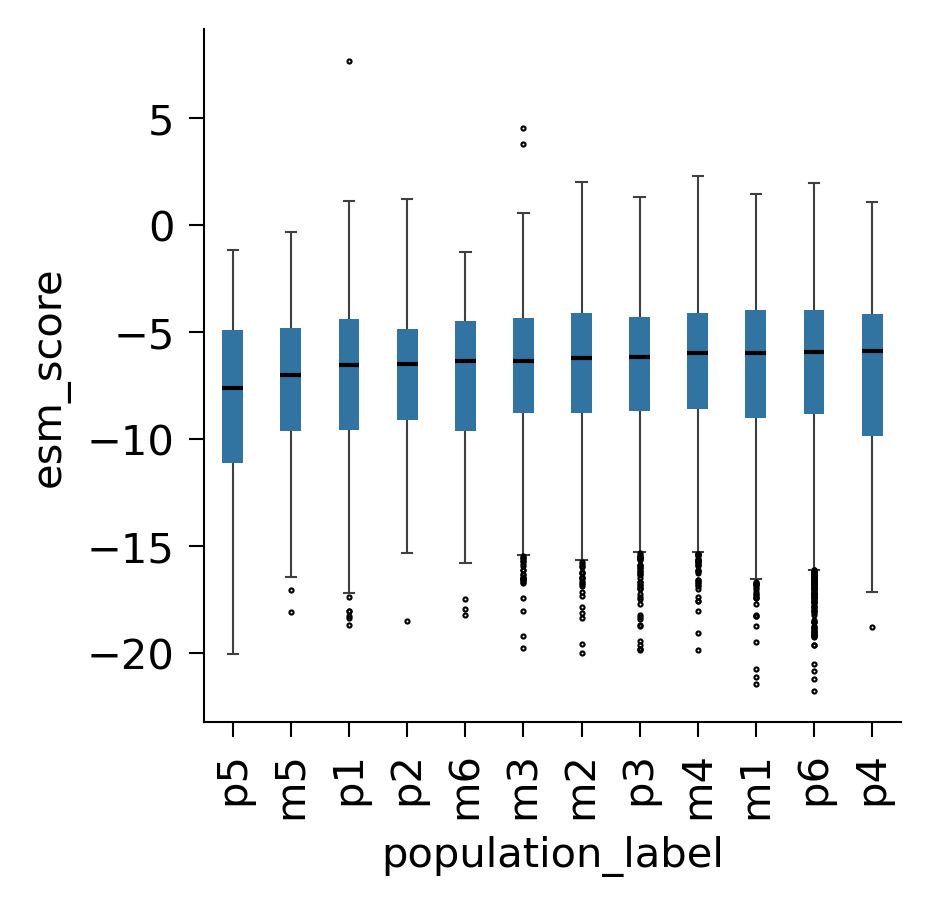

In [64]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi = 300)
# 1. Compute median of each population_label
median_order = (
    all_mutation_with_esm_1b_score_drop_na_unique_mutation
    .groupby("population_label")["esm_score"]
    .median()
    .sort_values()
    .index
)

# 2. Plot boxplot with sorted order
sns.boxplot(
    data=all_mutation_with_esm_1b_score_drop_na_unique_mutation,
    x="population_label",
    y="esm_score",
    order=median_order,
    # ax =ax,
    boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1
)
ax = utility.custom_figure_axis(ax=ax)


In [60]:
p_mut_non_mut = utility.man_whiteney(all_mutation_with_esm_1b_score_drop_na_unique_mutation[all_mutation_with_esm_1b_score_drop_na_unique_mutation["mutator_type"]=="mutator"]["esm_score"], all_mutation_with_esm_1b_score_drop_na_unique_mutation[all_mutation_with_esm_1b_score_drop_na_unique_mutation["mutator_type"]=="non_mutator"]["esm_score"])
print(f"The one sided p - value between mutator and non- mutator is {p_mut_non_mut}")

The one sided p - value between mutator and non- mutator is 1.3054237076473987e-09


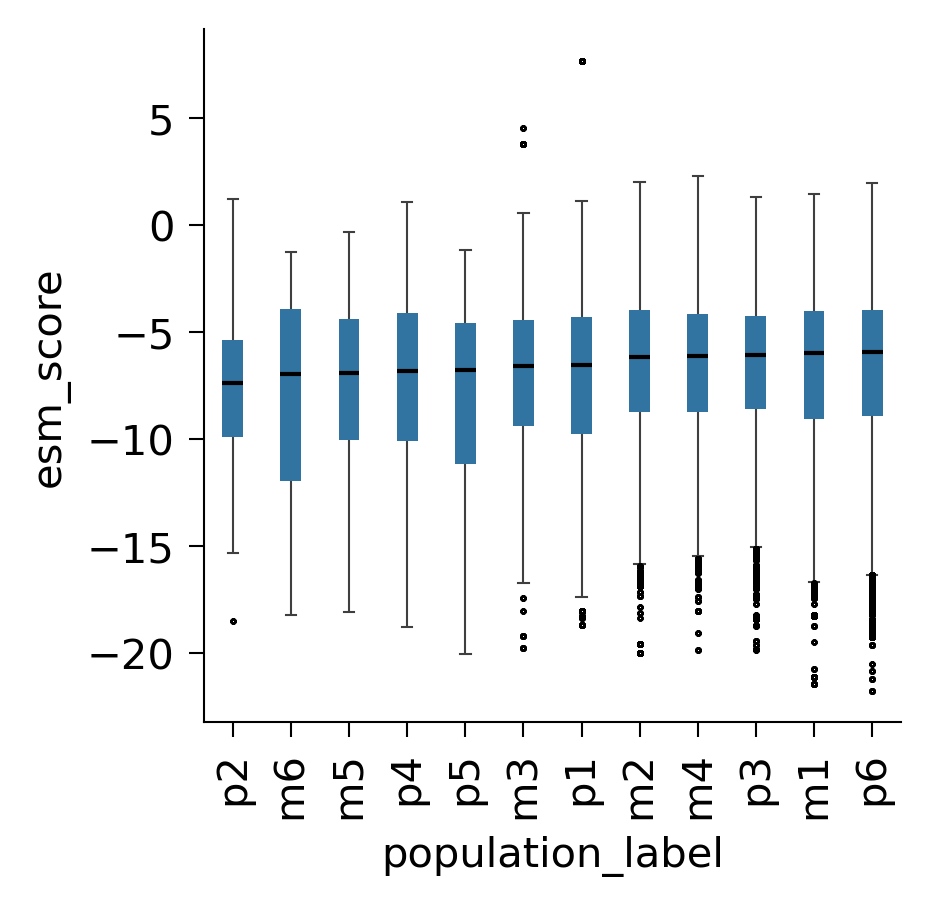

In [65]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi = 300)
# 1. Compute median of each population_label
median_order = (
    all_mutation_with_esm_1b_score_drop_na
    .groupby("population_label")["esm_score"]
    .median()
    .sort_values()
    .index
)

# 2. Plot boxplot with sorted order
sns.boxplot(
    data=all_mutation_with_esm_1b_score_drop_na,
    x="population_label",
    y="esm_score",
    order=median_order,
    # ax =ax,
    boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1
)
ax = utility.custom_figure_axis(ax=ax)


In [68]:
# all_mutation_with_esm_1b_score_drop_na

In [69]:
all_mutation_with_esm_1b_score_drop_na

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type,evolved_kGain,essentiality_status,esm_score,Allele
0,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding,-6.869305,non-essential,-6.072133,C->T
1,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding,-0.911021,non-essential,-12.324469,G->A
2,chrI,1156229,rne,G,A,p1,missense,1,0,chrI_G_1156229_A_p1_0,non_mutator,TGCGGTTCGGCAACCTGAA,TGCGGTTCGACAACCTGAA,-4.095615,chrI_G_1156229_A_p1,coding,-4.095615,essential,-3.581650,G->A
3,chrI,1507395,ydcE,A,G,p1,missense,1,0,chrI_A_1507395_G_p1_0,non_mutator,CCCAAATGGAGGCTTTGAT,CCCAAATGGGGGCTTTGAT,-2.574519,chrI_A_1507395_G_p1,coding,-2.574519,non-essential,-5.345155,A->G
4,chrI,2538060,yfgC,G,A,p1,missense,1,0,chrI_G_2538060_A_p1_0,non_mutator,CTCAACCTGGCAAACGCTT,CTCAACCTGACAAACGCTT,-9.650866,chrI_G_2538060_A_p1,coding,-9.650866,non-essential,-11.184139,G->A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495832,chrI,4278538,yjcP,T,A,m6,missense,53,57500,chrI_T_4278538_A_m6_57500,non_mutator,GTAAGCGGCTGGTTAAGCC,GTAAGCGGCAGGTTAAGCC,-2.149434,chrI_T_4278538_A_m6,coding,-0.033042,non-essential,-12.553349,T->A
495833,chrI,4293239,phnP,G,A,m6,missense,1,57500,chrI_G_4293239_A_m6_57500,non_mutator,ATCAGCCACGCATCAAACT,ATCAGCCACACATCAAACT,-7.141949,chrI_G_4293239_A_m6,coding,-3.984530,non-essential,-5.055573,G->A
495834,chrI,4358286,frdC,G,T,m6,missense,53,57500,chrI_G_4358286_T_m6_57500,non_mutator,AATAACCGGGTTTTGTAAA,AATAACCGGTTTTTGTAAA,5.235601,chrI_G_4358286_T_m6,coding,7.824229,non-essential,-6.610047,G->T
495835,chrI,4378108,miaA,T,G,m6,missense,17,57500,chrI_T_4378108_G_m6_57500,non_mutator,GGCGCTTTTTGCCCGAGGA,GGCGCTTTTGGCCCGAGGA,-9.977740,chrI_T_4378108_G_m6,coding,-7.204170,essential,-2.136348,T->G


In [70]:
p_mut_non_mut = utility.man_whiteney(all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na["mutator_type"]=="mutator"]["esm_score"], all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na["mutator_type"]=="non_mutator"]["esm_score"])
print(f"The one sided p - value between mutator and non- mutator is {p_mut_non_mut}")

The one sided p - value between mutator and non- mutator is 1.9945789413089605e-208
